In [1]:
from pathlib import Path
import math, re, collections, numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

plt.rcParams.update({"figure.figsize": (6, 6)})

# %%
# 🔧 Configuration
GT_DIR             = Path("/NAS/mmaiurov/Datasets/rat_neurons_patches64/images")
PRED_DIR           = Path("/NAS/mmaiurov/Datasets/rat_neurons_patches64/results")
GT_IMAGE_SUFFIX    = "_image.tiff"   # raw patch
GT_MASK_SUFFIX     = "_seg.tiff"     # GT mask patch
PRED_MASK_SUFFIX   = "_image.tiff"   # predicted mask patch
PATCH_SIZE         = 64
STRIDE             = 32
ORIG_SHAPE         = (61, 964, 1292) # before z-pad ➜ after pad Z=64
IOU_THR            = 0.50
TOP_K_SLICES       = 5

# Derived grid size (rows Py, cols Px)
Py = math.floor((ORIG_SHAPE[1] - PATCH_SIZE) / STRIDE) + 1  # 29
Px = math.floor((ORIG_SHAPE[2] - PATCH_SIZE) / STRIDE) + 1  # 39
print(f"Patch grid: {Py} rows × {Px} cols (y × x)")


Patch grid: 29 rows × 39 cols (y × x)


In [2]:
def _dice(tp, fp, fn):
    return 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 1.0

def _precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) else 1.0

def _recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) else 1.0

# %%
# 🤝 Instance matching (greedy IoU)

def match_instances(gt_lbl: np.ndarray, pr_lbl: np.ndarray, iou_thr: float = IOU_THR):
    gt_ids = np.unique(gt_lbl)[1:]
    pr_ids = np.unique(pr_lbl)[1:]
    gt_masks = {gid: gt_lbl == gid for gid in gt_ids}
    pr_masks = {pid: pr_lbl == pid for pid in pr_ids}

    ious = {}
    for gid, gm in gt_masks.items():
        gsum = gm.sum()
        for pid, pm in pr_masks.items():
            inter = np.logical_and(gm, pm).sum()
            if inter == 0:
                continue
            union = gsum + pm.sum() - inter
            ious[(gid, pid)] = inter / union

    tp = 0; matched_gt = set(); matched_pr = set()
    for (gid, pid), iou in sorted(ious.items(), key=lambda kv: kv[1], reverse=True):
        if iou < iou_thr or gid in matched_gt or pid in matched_pr:
            continue
        matched_gt.add(gid); matched_pr.add(pid); tp += 1
    fp = len(pr_ids) - tp
    fn = len(gt_ids) - tp
    return tp, fp, fn

# %%
# 🗂️ Group patches by recording & count preds
base_re = re.compile(r"^(.*)_p(\d{4})_seg\.tif{1,2}$")
base_to_patches: dict[str, list[tuple[int, Path]]] = collections.defaultdict(list)
pred_counts: dict[str, int] = collections.defaultdict(int)

for seg_path in GT_DIR.glob(f"*{GT_MASK_SUFFIX.replace('.tiff','.tif*')}"):
    m = base_re.match(seg_path.name)
    if not m: continue
    base, idx = m.group(1), int(m.group(2))
    base_to_patches[base].append((idx, seg_path))
    pred_name = re.sub(r"_seg\.tif{1,2}$", PRED_MASK_SUFFIX, seg_path.name)
    if (PRED_DIR / pred_name).exists():
        pred_counts[base] += 1

if not pred_counts:
    raise ValueError("No predictions found – verify PRED_DIR & suffixes")

best_base = max(pred_counts, key=pred_counts.get)
print(f"Chosen base: {best_base}  (pred {pred_counts[best_base]} / {len(base_to_patches[best_base])})")

idx_paths = sorted(base_to_patches[best_base], key=lambda t: t[0])

# %%
# 🏗️ Assemble volumes *only where predictions exist*
# ──────────────────────────────────────────────────────
Z_DIM = PATCH_SIZE
Y_DIM = PATCH_SIZE + (Py - 1) * STRIDE
X_DIM = PATCH_SIZE + (Px - 1) * STRIDE

orig_vol  = np.zeros((Z_DIM, Y_DIM, X_DIM), dtype=np.float32)
gt_vol    = np.zeros((Z_DIM, Y_DIM, X_DIM), dtype=np.uint16)
pred_vol  = np.zeros_like(gt_vol)
eval_mask = np.zeros((Z_DIM, Y_DIM, X_DIM), dtype=bool)  # where predictions exist
label_offset = 0

for idx, seg_path in tqdm(idx_paths, desc="Stitching"):
    row, col = divmod(idx, Px)
    y0, x0 = row * STRIDE, col * STRIDE
    pred_name = re.sub(r"_seg\.tif{1,2}$", PRED_MASK_SUFFIX, seg_path.name)
    pred_path = PRED_DIR / pred_name
    if not pred_path.exists():
        continue  # skip whole patch – no prediction

    # GT mask patch
    gt_patch = tiff.imread(seg_path)
    gt_vol[:, y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE] = gt_patch

    # Raw intensity patch
    img_name = re.sub(r"_seg\.tif{1,2}$", GT_IMAGE_SUFFIX, seg_path.name)
    img_patch = tiff.imread(GT_DIR / img_name).astype(np.float32)
    orig_vol[:, y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE] = img_patch

    # Pred mask patch
    pr_patch = tiff.imread(pred_path)
    if pr_patch.max() > 0:
        pr_patch = np.where(pr_patch > 0, pr_patch + label_offset, 0)
        label_offset = pr_patch.max()
    pred_vol[:, y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE] = pr_patch

    # mark eval region
    eval_mask[:, y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE] = True

if not eval_mask.any():
    raise ValueError("Eval mask empty – something went wrong with predictions")

print("Volumes ready →", gt_vol.shape, "; eval voxels:", eval_mask.sum())

Chosen base: 2024-01-31_10-54-33_dic_8  (pred 1131 / 1131)


Stitching:   0%|          | 0/1131 [00:00<?, ?it/s]

Volumes ready → (64, 960, 1280) ; eval voxels: 78643200


In [3]:
mask_nonzero = orig_vol > 0
orig_min, orig_max = orig_vol[mask_nonzero].min(), orig_vol[mask_nonzero].max()
orig_vol = (orig_vol - orig_min) / (orig_max - orig_min + 1e-6)

# %%
# 🧮 Metrics *inside eval_mask*

gt_bin   = np.logical_and(gt_vol > 0, eval_mask)
pred_bin = np.logical_and(pred_vol > 0, eval_mask)

TP_px = np.logical_and(gt_bin, pred_bin).sum()
FP_px = np.logical_and(~gt_bin, pred_bin).sum()
FN_px = np.logical_and(gt_bin, ~pred_bin).sum()

dice_px = _dice(TP_px, FP_px, FN_px)
prec_px = _precision(TP_px, FP_px)
rec_px  = _recall(TP_px, FN_px)

# Zero‑out labels outside eval mask for instance metrics
gt_lbl_eval   = np.where(eval_mask, gt_vol, 0)
pred_lbl_eval = np.where(eval_mask, pred_vol, 0)

TP_i, FP_i, FN_i = match_instances(gt_lbl_eval, pred_lbl_eval)
dice_i = _dice(TP_i, FP_i, FN_i)
prec_i = _precision(TP_i, FP_i)
rec_i  = _recall(TP_i, FN_i)

print("\n### Metrics on predicted region ###")
print(f"Pixel Dice  : {dice_px:.3f} | Prec {prec_px:.3f} | Rec {rec_px:.3f}\n" \
      f"Instance F1: {dice_i:.3f} | Prec {prec_i:.3f} | Rec {rec_i:.3f}")


### Metrics on predicted region ###
Pixel Dice  : 0.601 | Prec 0.489 | Rec 0.781
Instance F1: 0.000 | Prec 0.000 | Rec 0.000


Best z slices: [40  1 11  8  9] Dice: [0.73334281 0.73026019 0.72840815 0.72272955 0.72163812]
Worst z slices: [ 0 62 63  5 23] Dice: [0.         0.         0.         0.42103041 0.43178504]


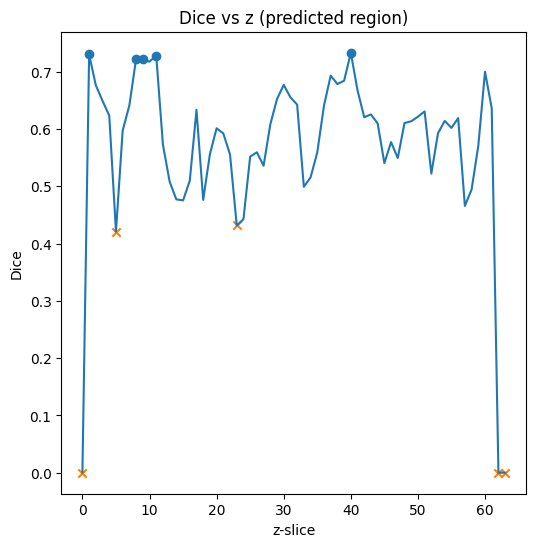

In [4]:
dice_profile = []
valid_slices = []
for z in range(Z_DIM):
    if not eval_mask[z].any():
        dice_profile.append(np.nan)
        continue
    valid_slices.append(z)
    g, p = gt_bin[z], pred_bin[z]
    tp = np.logical_and(g, p).sum()
    fp = np.logical_and(~g, p).sum()
    fn = np.logical_and(g, ~p).sum()
    dice_profile.append(_dice(tp, fp, fn))

dice_profile = np.array(dice_profile)

best_idx  = np.argsort(-dice_profile[valid_slices])[:TOP_K_SLICES]
worst_idx = np.argsort(dice_profile[valid_slices])[:TOP_K_SLICES]

best_slices  = np.array(valid_slices)[best_idx]
worst_slices = np.array(valid_slices)[worst_idx]

print("Best z slices:", best_slices, "Dice:", dice_profile[best_slices])
print("Worst z slices:", worst_slices, "Dice:", dice_profile[worst_slices])

plt.figure(); plt.plot(range(Z_DIM), dice_profile)
plt.xlabel("z‑slice"); plt.ylabel("Dice"); plt.title("Dice vs z (predicted region)")
plt.scatter(best_slices, dice_profile[best_slices], marker='o');
plt.scatter(worst_slices, dice_profile[worst_slices], marker='x');
plt.show()



—— 5 Best slices —


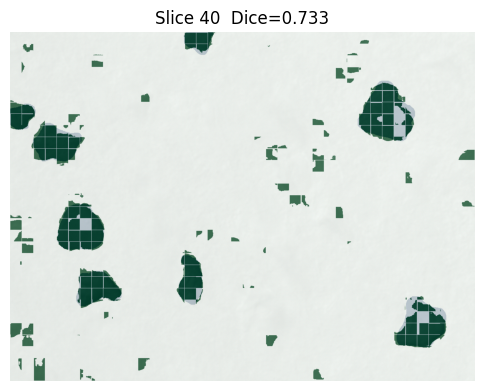

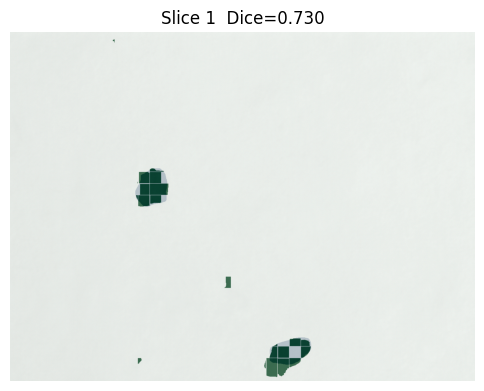

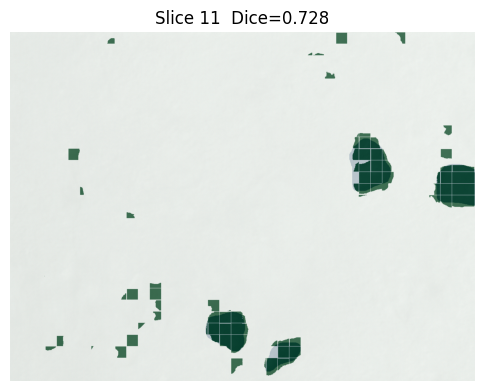

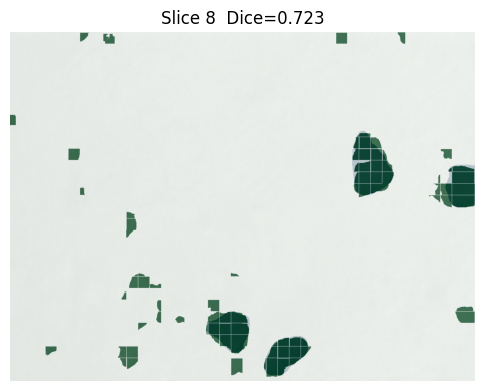

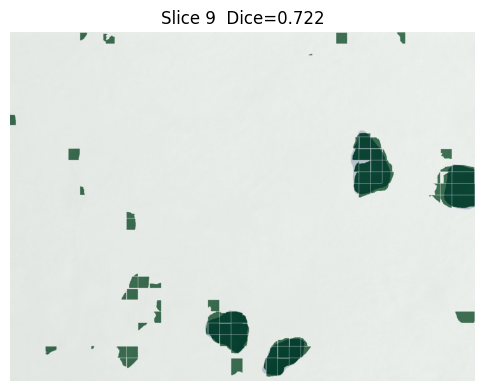


—— 5 Worst slices —


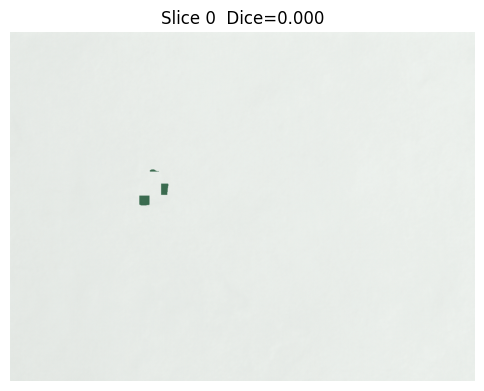

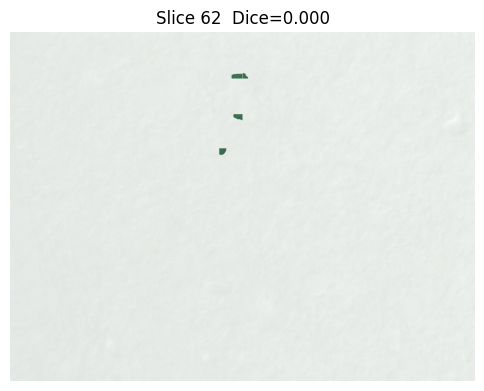

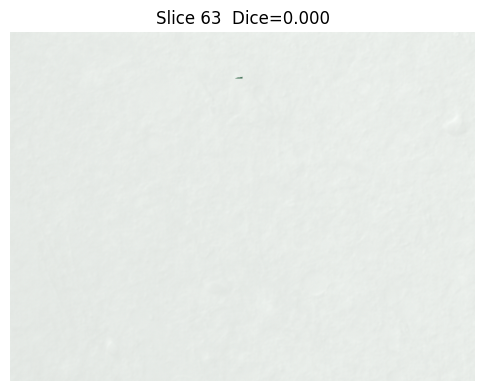

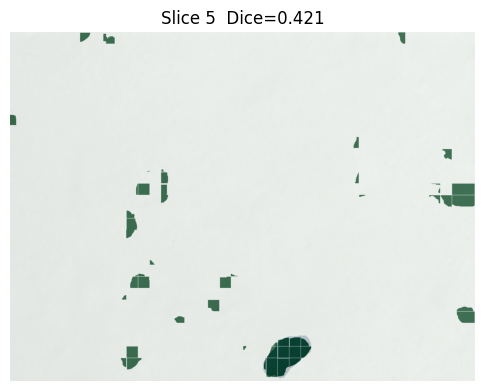

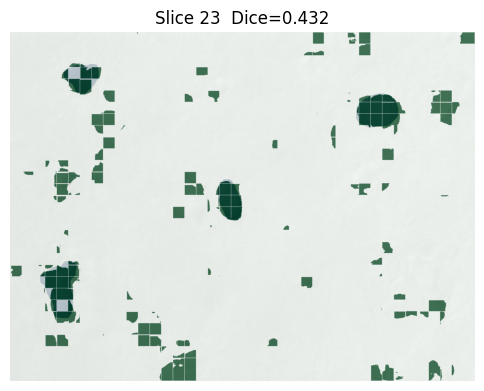


Reference slice z=32


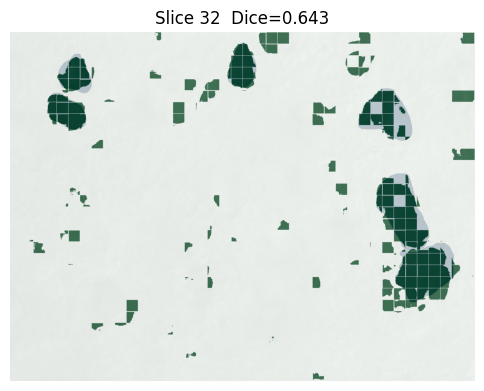

In [8]:
def show_slice(z):
    fig, ax = plt.subplots()
    ax.imshow(orig_vol[z], cmap='gray', vmin=0, vmax=1)
    ax.imshow(gt_bin[z], alpha=0.7, cmap='Blues')
    ax.imshow(pred_bin[z], alpha=0.7, cmap='Greens')
    ax.set_title(f"Slice {z}  Dice={dice_profile[z]:.3f}")
    ax.axis('off')

print("\n—— 5 Best slices —")
for z in best_slices:
    show_slice(int(z))
plt.show()

print("\n—— 5 Worst slices —")
for z in worst_slices:
    show_slice(int(z))
plt.show()

# show an arbitrary reference slice where predictions exist (mid of valid)
mid_valid = valid_slices[len(valid_slices)//2]
print(f"\nReference slice z={mid_valid}")
show_slice(mid_valid);
plt.show()

In [11]:
def render_slice(z, vmin=0, vmax=1):
    """Возвращает RGB-изображение с наложением GT и Pred."""
    # базовый слой — серое (H,W) → (H,W,3)
    base = np.dstack([orig_vol[z]]*3)

    # наложим маски в свои каналы (blue и red)
    gt_mask   = gt_bin[z].astype(bool)
    pred_mask = pred_bin[z].astype(bool)

    overlay = base.copy()
    # — GT: добавляем синий канал
    overlay[..., 2][gt_mask] = 1        # blue
    # — Pred: красный канал
    overlay[..., 0][pred_mask] = 1      # red
    # — смешиваем с альфой 0.5
    out = 0.5*base + 0.5*overlay
    return np.clip(out, 0, 1)

def show_best_worst(best_slices, worst_slices):
    """Одна фигура 2×5: best сверху, worst снизу."""
    all_slices = list(best_slices) + list(worst_slices)
    imgs = [render_slice(z) for z in all_slices]

    H, W, _ = imgs[0].shape
    mosaic = np.zeros((2*H, 5*W, 3), dtype=imgs[0].dtype)
    for i, img in enumerate(imgs):
        r, c = divmod(i, 5)             # 0/1, 0-4
        mosaic[r*H:(r+1)*H, c*W:(c+1)*W] = img

    plt.figure(figsize=(15, 6))
    plt.imshow(mosaic, vmin=0, vmax=1)
    plt.title(
        "Top-5 best slices (row 1) and worst slices (row 2) GT - Blue, Pred - Red, TP - Pink, FP - Red\n"
        + "Dice scores: "
        + ", ".join(f"{z}:{dice_profile[z]:.3f}" for z in all_slices),
        fontsize=10
    )
    plt.axis("off")
    plt.show()

—— Composite figure: 5 best + 5 worst ——


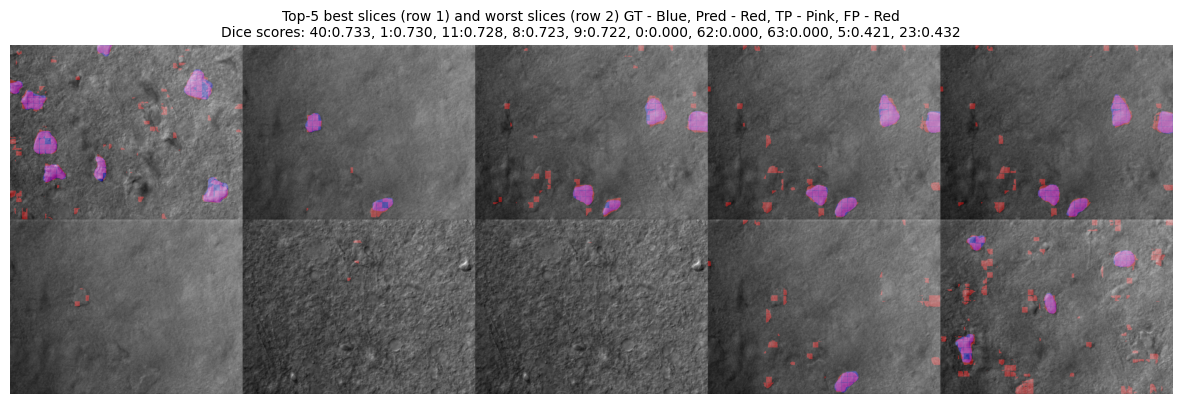

In [12]:
print("—— Composite figure: 5 best + 5 worst ——")
show_best_worst(best_slices, worst_slices)